# Pre-processing from LPI radar signals

In [2]:
import os
import glob
import pandas as pd
import json
import re

raw_data_path = "/data/kiwan/dataset-CWD-1000test/"
signal_types = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

output_json = 'LPI12 dataset test.json'

signals_dict = {}

def extract_snr_from_filename(filename):
    match = re.search(r'snr-?0*(\d+)', filename)
    if match:
        return int(match.group(1))
    return None

for signal in signal_types:
    signal_csvs = glob.glob(os.path.join(raw_data_path, signal, '*.csv'))
    signals_dict[signal] = {}  

    for csv_file in signal_csvs:
        snr_value = extract_snr_from_filename(csv_file)
        print(f"Processing {csv_file} with SNR {snr_value}", end='\r')
    
        if snr_value is not None:
            df = pd.read_csv(csv_file, header=None)
        
            if snr_value not in signals_dict[signal]:
                signals_dict[signal][snr_value] = []
        
            signals_dict[signal][snr_value].extend(df.values.tolist())
        else:
            print(f"Warning: SNR not found in {csv_file}")

with open(output_json, 'w') as f:
    json.dump(signals_dict, f, indent=4)

print(f"All signals have been merged by SNR into {output_json}")


All signals have been merged by SNR into LPI12 dataset test.jsoncsv with SNR 01616 01616


In [1]:

import os
import argparse
import numpy as np

import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import models._config as c
from models.LSTM import BiLSTM
from models.Attention import Transformer
from explainer import LRP
    
criterion = nn.CrossEntropyLoss()

parser = argparse.ArgumentParser(description='Training parameters')
parser.add_argument('-m', '--mode', type=str, default='train', help='Mode of operation (train/eval)')

parser.add_argument('-smin','--snr_min', type=int, default=0, help='Minimum SNR value')
parser.add_argument('-smax','--snr_max', type=int, default=16, help='Maximum SNR value')
parser.add_argument('--split_size', type=float, default=0.8, help='Train/Test split size')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
parser.add_argument('--num_epochs', type=int, default=500, help='Number of epochs for training')
parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate for optimizer')
parser.add_argument('--weight_decay', type=float, default=1e-5, help='Weight decay for optimizer')
parser.add_argument('--input_size', type=int, default=2, help='Input size for the model')
parser.add_argument('--hidden_size', type=int, default=128, help='Hidden size for the model')
parser.add_argument('--num_layers', type=int, default=2, help='Number of layers in the model')
parser.add_argument('--num_classes', type=int, default=len(c.signalTypes[:c.typeSize]), help='Number of output classes')

args = parser.parse_args(args=[])

params = {
    'snr_min': args.snr_min,
    'snr_max': args.snr_max,
    'split_size': args.split_size,
    'batch_size': args.batch_size,
    'num_epochs': args.num_epochs,
    'learning_rate': args.learning_rate,
    'weight_decay': args.weight_decay,
    'input_size': args.input_size,
    'hidden_size': args.hidden_size,
    'num_layers': args.num_layers,
    'num_classes': args.num_classes
}

def train_set(dataset, mtype='LSTM'):
    print(f"Size of train dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        print(f"\nTraining model for SNR: {snr}...")
        ckpt = os.path.join("./ckpts/", snr_str:=f"SNR-{snr}dB" if snr != 0 else " 0dB")
        os.makedirs(ckpt, exist_ok=True)
        
        model = BiLSTM(params['input_size'], params['hidden_size'], params['num_layers'], params['num_classes'])
        model.to(c.device)
        
        criterion = nn.CrossEntropyLoss()
        # criterion = LabelSmoothingLoss(classes=params['num_classes'], smoothing=0.1).to(c.device)
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                                                    weight_decay=params['weight_decay'])
        
        snr_dataset = [(data, label, data_snr, length) for data, label, data_snr, length in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=model.collate)
            
        best_state, best_loss = model.train_model(snr_loader, criterion, optimizer, params['num_epochs'], c.device, snr_str, ckpt)

        save_point = f'{ckpt}/{mtype}_{snr_str}_{best_loss:.4f}.pt'
        
        torch.save(best_state, save_point)
        print(f"Model checkpoint saved at {save_point}")

def eval_set(dataset, mtype='LSTM'):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"SNR-{snr}dB" if snr != 0 else " 0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt") and f.startswith("LSTM")]
        
        model = BiLSTM(params['input_size'], params['hidden_size'], params['num_layers'], params['num_classes']).to(c.device)
        model.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        model.eval()
        
        criterion = nn.CrossEntropyLoss()
        snr_dataset = [(data, label, data_snr, length) for data, label, data_snr, length in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=model.collate)
        
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in snr_loader:
                data, labels, length = batch[0].to(c.device), batch[1].to(c.device), batch[3]
                outputs = model(data, length)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
        acc = correct / total * 100
        avg_loss = total_loss / len(snr_loader)
        
        print(f"SNR -{snr}dB | Accuracy: {acc:.2f}% | Average Loss: {avg_loss:.4f}")
        
        
import matplotlib.pyplot as plt
import numpy as np
import os

def explain_set(dataset, mtype='LSTM'):
    """
    설명 및 기여도 분석을 위한 함수.
    주어진 데이터셋과 모델을 사용하여 각 데이터에 대한 LRP 기여도 계산 및 시각화.
    
    Parameters:
        - dataset: 입력 데이터셋
        - mtype: 모델 타입 ('LSTM', 'Attention' 등)
    """
    print(f"Size of explain dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        print(f"\nExplaining model for SNR: {snr}...")
        ckpt = os.path.join("./ckpts/", snr_str := f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")  and f.startswith("LSTM")]

        # 모델 타입에 따라 BiLSTM 또는 Transformer 로드
        if mtype == 'LSTM':
            model = BiLSTM(params['input_size'], params['hidden_size'],
                           params['num_layers'], params['num_classes']).to(c.device)
        elif mtype == 'Attention':
            model = Transformer(params['input_size'], params['hidden_size'],
                                params['num_layers'], params['num_classes'], nhead=8, dropout=0.3).to(c.device)

        model.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        model.eval()
        
        # LRP 적용 객체
        lrp = LRP(model)

        # SNR에 따른 데이터 필터링
        snr_dataset = [(data, label, data_snr) for data, label, data_snr in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=model.collate)

        # 결과 저장 디렉토리 생성
        results_dir = os.path.join("./explanations/", f"{mtype}_{snr_str}")
        os.makedirs(results_dir, exist_ok=True)

        explanation_results = []

        # LRP를 사용하여 기여도 분석 및 시각화
        with torch.no_grad():
            for i, batch in enumerate(snr_loader):
                data, labels = batch[0].to(c.device), batch[1].to(c.device)
                
                # LRP 기법으로 relevance 계산
                relevance, _, attn_weights = lrp.get_relevance(data)

                for j in range(data.size(0)):
                    sample_data = data[j].cpu().numpy()
                    sample_relevance = relevance[j].cpu().numpy()
                    label = labels[j].item()

                    explanation_results.append((sample_relevance, label))

                    # 히트맵 시각화
                    fig, ax = plt.subplots(figsize=(12, 6))
                    time_steps = np.arange(sample_data.shape[0])

                    # 원본 신호 플롯
                    ax.plot(time_steps, sample_data[:, 0], label='Signal', color='blue')
                    ax.set_title(f'Sample {i * params["batch_size"] + j} - SNR: {snr}dB, Label: {label}')
                    ax.set_xlabel('Time Step')
                    ax.set_ylabel('Amplitude')

                    # 히트맵 오버레이 (relevance score)
                    im = ax.imshow(sample_relevance.T, aspect='auto', cmap='hot', alpha=0.6,
                                   extent=[0, sample_data.shape[0],
                                           np.min(sample_data), np.max(sample_data)])

                    # Attention 가중치 시각화 추가
                    attn_map = attn_weights[j].cpu().numpy()
                    ax.plot(time_steps, attn_map, color='red', alpha=0.5, label='Attention Score')

                    # 컬러바 추가
                    cbar = plt.colorbar(im, ax=ax)
                    cbar.set_label('Relevance Score')

                    # 시각화 저장
                    plot_path = os.path.join(results_dir, f"sample_{i * params['batch_size'] + j}_heatmap.png")
                    plt.savefig(plot_path)
                    plt.close()
                    print(f"Heatmap for sample {i * params['batch_size'] + j} saved to {plot_path}")

        print(f"LRP explanations and visualizations for SNR {snr} saved in {results_dir}")

    return explanation_results
              
from dataset.RadarDataset import RadarSignalDataset  

mode = 'eval'
model_type = 'LSTM'
if __name__ == "__main__":
    if mode == 'train':
        train_dataset = RadarSignalDataset(c.TrainData, c.signalTypes[0:c.typeSize], snr_max=17)
        train_set(train_dataset, mtype=model_type)
    elif mode == 'eval':
        test_dataset = RadarSignalDataset(c.TestData, c.signalTypes[0:c.typeSize], snr_max=17)
        eval_set(test_dataset, mtype=model_type)
    elif mode == 'explain':
        explain_dataset = RadarSignalDataset(c.TestData, c.signalTypes[0:c.typeSize], snr_max=17)
        # explain_set(explain_dataset)
    else:
        print("Invalid mode of operation. Choose from 'train', 'eval', 'explain'")
        


Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!
Data loading for 'P1'.....Done!
Data loading for 'P2'.....Done!
Data loading for 'P3'.....Done!
Data loading for 'P4'.....Done!
Data loading for 'T1'.....Done!
Data loading for 'T2'.....Done!
Data loading for 'T3'.....Done!
Data loading for 'T4'.....Done!
Size of test dataset: 32400
SNR -0dB | Accuracy: 95.67% | Average Loss: 0.1714
SNR -2dB | Accuracy: 86.33% | Average Loss: 0.6691
SNR -4dB | Accuracy: 86.44% | Average Loss: 0.7167
SNR -6dB | Accuracy: 81.94% | Average Loss: 0.7949
SNR -8dB | Accuracy: 80.56% | Average Loss: 1.0489
SNR -10dB | Accuracy: 74.19% | Average Loss: 1.2854
SNR -12dB | Accuracy: 70.81% | Average Loss: 1.9260
SNR -14dB | Accuracy: 53.06% | Average Loss: 3.2012
SNR -16dB | Accuracy: 19.97% | Average Loss: 6.9119


In [3]:
import torch
import torch.nn.functional as F

class LRP:
    def __init__(self, model, epsilon=1e-5):
        self.model = model
        self.epsilon = epsilon
        self.model.eval()

    def get_relevance(self, x, target=None):
        """
        입력 데이터 x에 대한 relevance 점수를 계산합니다.
        Args:
            x (torch.Tensor): 입력 데이터 (batch_size, seq_len, input_size)
            target (torch.Tensor): 타겟 클래스 (optional)
        Returns:
            relevance (torch.Tensor): relevance 점수 (batch_size, seq_len)
            attention_weights (torch.Tensor): attention 가중치 (batch_size, seq_len)
        """
        # 순전파 수행
        x.requires_grad = True
        output, hid_outputs, attn_weights = self.forward(x, lstm_outputs=True)  # LSTM outputs: [batch_size, seq_len, hidden_size * 2]

        # 예측된 클래스 선택
        if target is None:
            target = torch.argmax(output, dim=1)
        else:
            target = torch.tensor(target).to(x.device)

        # 모델 예측에 대한 기여도 초기화
        relevance = torch.zeros_like(output)
        for i in range(output.size(0)):
            relevance[i, target[i]] = output[i, target[i]]

        # LRP relevance 역전파 계산
        relevance = self.compute_relevance(hid_outputs, relevance)

        return relevance, output, attn_weights

    def forward(self, x, lstm_outputs=False):
        """모델의 순전파를 수행하고 LSTM hidden outputs 및 attention weights를 반환합니다."""
        return self.model(x, lstm_outputs)

    def compute_relevance(self, hiddens, relevance):
        """
        LSTM 모델에서 relevance 역전파 수행.
        Args:
            hiddens (torch.Tensor): LSTM hidden states (batch_size, seq_len, hidden_size * 2)
            relevance (torch.Tensor): 모델의 출력 레벨에서 계산된 relevance
        Returns:
            total_relevance (torch.Tensor): 각 타임 스텝에 대한 relevance (batch_size, seq_len, hidden_size * 2)
        """
        batch_size, seq_len, hidden_size2 = hiddens.size()  # hidden_size2 = hidden_size * 2
        hidden_size = hidden_size2 // 2
        
        # Forward LSTM에 대한 relevance 계산
        h_fw, h_bw = hiddens[:, :, :hidden_size], hiddens[:, :, hidden_size:]
        rel_fw, rel_bw = torch.zeros_like(h_fw), torch.zeros_like(h_bw)
        
        for t in reversed(range(seq_len)):
            h_t_fw = h_fw[:, t, :]  # [batch_size, hidden_size]
            h_t_bw = h_bw[:, t, :]  # [batch_size, hidden_size]
            
            # Forward 방향 relevance 계산
            z_t_fw = F.linear(h_t_fw, self.model.fc.weight[:, :hidden_size], self.model.fc.bias) + self.epsilon  # [batch_size, 4]
            s_t_fw = relevance / (z_t_fw + self.epsilon)  # [batch_size, 4]
            c_t_fw = torch.matmul(s_t_fw, self.model.fc.weight[:, :hidden_size])  # [batch_size, hidden_size]
            rel_fw[:, t, :] = h_t_fw * c_t_fw  # [batch_size, hidden_size]

            # Backward 방향 relevance 계산
            z_t_bw = F.linear(h_t_bw, self.model.fc.weight[:, hidden_size:], self.model.fc.bias) + self.epsilon  # [batch_size, 4]
            s_t_bw = relevance / (z_t_bw + self.epsilon)  # [batch_size, 4]
            c_t_bw = torch.matmul(s_t_bw, self.model.fc.weight[:, hidden_size:])  # [batch_size, hidden_size]
            rel_bw[:, t, :] = h_t_bw * c_t_bw  # [batch_size, hidden_size]
        
        # Forward와 Backward relevance 합산
        total_relevance = rel_fw + rel_bw  # [batch_size, seq_len, hidden_size * 2]
        
        return total_relevance



In [ ]:
explain_set(explain_dataset)

In [11]:
import visdom
import torch
import torch.nn as nn
import models._config as c
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from matplotlib import pyplot as plt

class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size)) 
        
    def forward(self, hidden_states):
        attn_weights = torch.tanh(self.attn(hidden_states))                           # [batch_size, seq_len, hidden_size]
        attn_weights = attn_weights.matmul(self.v)
        attn_weights = torch.softmax(attn_weights, dim=1)                             # [batch_size, seq_len]
        
        context = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1) # [batch_size, hidden_size * 2]
        return context, attn_weights
    
# Temporal Attention Layer (Zero-padding에 대한 가중치 조정 포함)
class TemporalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # BiLSTM이므로 hidden_size * 2
        self.v = nn.Parameter(torch.rand(hidden_size)) 
        
    def forward(self, hidden_states, mask=None):
        """
        hidden_states: [batch_size, seq_len, hidden_size * 2]
        mask: [batch_size, seq_len] - zero-padding mask
        """
        attn_weights = torch.tanh(self.attn(hidden_states))  # [batch_size, seq_len, hidden_size]
        attn_weights = attn_weights.matmul(self.v)  # [batch_size, seq_len]

        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, -1e9)  # Zero-padding에 대해 큰 음수 부여

        attn_weights = F.softmax(attn_weights, dim=1)  # [batch_size, seq_len]에서 softmax로 중요도 결정
        
        # 가중치를 반영하여 각 타임 스텝의 hidden state를 곱해줌
        context = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_size * 2]
        return context, attn_weights

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self.attention = TemporalAttention(hidden_size)
        # self.multihead_attention = MultiHeadAttention(hidden_size * 2, num_heads)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bidirectional이므로 hidden_size * 2
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths, lstm_outputs=False):
        batch_size, seq_len, _ = x.size()

        # Initial hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        # PackedSequence로 변환하여 RNN/LSTM에서 패딩 무시
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM output
        packed_out, (hn, cn) = self.lstm(packed_x, (h0, c0))  # LSTM 통과
        
        # 다시 패딩된 시퀀스로 변환
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)

        # Zero-padding Mask 생성
        mask = torch.arange(seq_len).expand(batch_size, seq_len).to(x.device) < lengths.to(x.device).unsqueeze(1)
        
        # Attention with Zero-padding Mask 적용
        context, attn_weights = self.attention(out, mask)  # Self-Attention 통과
        
        out_last = self.dropout(context)  # Dropout
        out_fc = self.fc(out_last)  # Fully connected layer

        if lstm_outputs:
            return out_fc, out, attn_weights
        else:
            return out_fc


    def train_model(self, train_loader, criterion, optimizer, num_epochs, device, snr_str, ckpt):
        vis = visdom.Visdom()
        assert vis.check_connection(), "Visdom 서버를 실행해주세요: python -m visdom.server"

        losses = []  
        vis_window = vis.line(
            X=torch.zeros((1,)).cpu(),
            Y=torch.zeros((1,)).cpu(),
            opts=dict(xlabel='Epoch', ylabel='Loss', title=f'Training Loss for SNR {snr_str}', legend=['Loss'])
        )
        
        best_loss = float('inf')  # Best loss 초기화
        best_state = None

        for epoch in range(num_epochs):
            self.train()  # 모델을 학습 모드로 설정
            running_loss = 0.0  # Epoch별로 누적할 Loss 초기화
            
            for data_batch, labels_batch, _, lengths_batch in train_loader:  # lengths_batch 추가
                data_batch = data_batch.to(device)
                labels_batch = labels_batch.to(device)
                lengths_batch = lengths_batch.cpu()  # 시퀀스 길이를 CPU로 이동

                optimizer.zero_grad() 
                
                # forward에 lengths_batch도 함께 전달
                outputs = self(data_batch, lengths_batch)  # self()는 forward()를 호출함
                
                # Loss 계산
                loss = criterion(outputs, labels_batch)
                loss.backward()  
                optimizer.step() 

                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            losses.append(avg_loss)

            # Visdom으로 Loss 그래프 업데이트
            vis.line(
                X=torch.tensor([epoch + 1]).cpu(),
                Y=torch.tensor([avg_loss]).cpu(),
                win=vis_window,
                update='append'
            )

            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')
            
            # Best loss 갱신
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_state = self.state_dict()

            if best_loss < 0.01:
                break

        return best_state, best_loss

    @staticmethod        
    def collate(batch):
        data, labels, snrs, lengths = zip(*batch)
        data_pad = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        
        labels = torch.tensor([c.label_mapping[label] for label in labels], dtype=torch.long)
        snrs = torch.tensor(snrs, dtype=torch.float32)
        lengths = torch.tensor(lengths, dtype=torch.long)  # 시퀀스 길이를 함께 전달

        return data_pad, labels, snrs, lengths


datasets = explain_dataset
model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
model.to(c.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
snr = 0
snr_dataset = [(data, label, data_snr, length) for data, label, data_snr, length in datasets if data_snr == snr]
snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=model.collate)

ckpt = os.path.join("./ckpts/", snr_str:=f"SNR-{snr}dB" if snr != 0 else " 0dB")
best_state, best_loss = model.train_model(snr_loader, criterion, optimizer, 64, c.device, "0dB", ckpt)

Setting up a new session...


Epoch [1/64], Loss: 2.3532
Epoch [2/64], Loss: 2.1926


KeyboardInterrupt: 

: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#for j in range(data.size(0)):
#   relevance = lrp.get_relevance(data[j]) # [seq_len, input_size]

class LRP:
    def __init__(self, model, epsilon=1e-5):
        self.model = model
        self.epsilon = epsilon
        self.model.eval()

    def forward(self, x, lstm_outputs):
        return self.model(x, lstm_outputs)
    
    def get_relevance(self, x, target=None):        
        x.requires_grad = True
        output, hiddens = self.forward(x, lstm_outputs=True) # [32, 4] | [32, 1495, 256]
        # output은 모델의 예측 결과, hid_outputs는 LSTM의 각 시간 스텝의 hidden state를 포함
        # output : [batch_size, num_classes], hiddens : [batch_size, seq_len, hidden_size]
        target = torch.argmax(output, dim=1) if target is None else torch.tensor(target).to(x.device)

        # 정답 클래스에 대한 기여도 초기화
        relevance = torch.zeros_like(output)
        for i in range(output.size(0)):
            relevance[i, target[i]] = output[i, target[i]]
        
        relevance = relevance.unsqueeze(1).expand(-1, hiddens.size(1), -1) # [batch_size, seq_len, num_classes]
        
        
        for module in reversed(list(self.model.modules())):
            if isinstance(module, nn.Linear):
                relevance = self.linear_lrp(module, hiddens, relevance)
            elif isinstance(module, nn.LSTM):
                relevance = self.bilstm_lrp(module, hiddens, relevance)
            elif isinstance(module, nn.ReLU) or isinstance(module, nn.Tanh):
                relevance = self.activation_lrp(module, hiddens, relevance)
                
        return relevance


    # hiddens : torch.Size([32, 1495, 256]) : [batch_size, seq_len, hidden_size] | relevance : torch.Size([32, 4])
    def linear_lrp(self, layer, hiddens, relevance): 
        print(hiddens.size())
        batch_size, seq_len, _ = hiddens.size()
        
        weight = layer.weight  # [num_classes, hidden_size]
        bias = layer.bias      # [num_classes]
        total_relevance = torch.zeros_like(hiddens)  # [batch_size, seq_len, hidden_size]

        for i in range(batch_size):
            hiddens_i = hiddens[i]                           # [seq_len, hidden_size]
            relevance_i = relevance[i]                       # [num_classes]
            total_relevance_i = torch.zeros_like(hiddens_i)  # [seq_len, hidden_size]

            for t in range(seq_len):
                h_t = hiddens_i[t, :]                              
                z_t = F.linear(h_t, weight, bias) + self.epsilon   
                s_t = relevance_i / z_t                            
                c_t = torch.matmul(s_t, weight)                    

                total_relevance_i[t, :] = h_t * c_t  # [hidden_size]

            total_relevance[i] = total_relevance_i

        print(total_relevance.size())  # total_relevance: [batch_size, seq_len, hidden_size]
        return total_relevance
    
    def bilstm_lrp(self, layer, hiddens, relevance):
        batch_size, seq_len, hidden_size2 = hiddens.size()
        hidden_size = hidden_size2 // 2                     # only one-direction hidden size
        
        h_fw, h_bw = hiddens[:, :, :hidden_size], hiddens[:, :, hidden_size:]
        rel_fw, rel_bw = torch.zeros_like(h_fw), torch.zeros_like(h_bw)
        
        for t in reversed(range(seq_len)):
            h_t_fw = h_fw[:, t, :]  # [batch_size, hidden_size]
 
            z_t_fw = F.linear(h_t_fw, layer.weight_ih_l0, layer.bias_ih_l0) + self.epsilon
                    
            
            
        
            s_t_fw = relevance / (z_t_fw + self.epsilon)
            c_t_fw = s_t_fw @ layer.weight_ih_l0[:hidden_size, :].t() 
            rel_fw[:, t, :] = h_t_fw * c_t_fw
            
            h_t_bw = h_bw[:, t, :]  # [batch_size, hidden_size]
            z_t_bw = F.linear(h_t_bw, layer.weight_ih_l0_reverse, layer.bias_ih_l0_reverse) + self.epsilon
            s_t_bw = relevance / (z_t_bw + self.epsilon)
            c_t_bw = s_t_bw @ layer.weight_ih_l0[hidden_size:, :].t()
            rel_bw[:, t, :] = h_t_bw * c_t_bw
            
        total_relevance = rel_fw + rel_bw
        print(f"total relevance: {total_relevance.size()}")
        return total_relevance
 
    def compute_lstm_relevance(self, layer, x, relevance, direction='forward'):
        """
        LSTM의 각 시간 스텝에 대해 relevance 계산.
        - layer: nn.LSTM 레이어
        - x: 입력 텐서
        - relevance: 기여도 텐서
        - direction: 'forward' or 'backward' (방향 선택)
        """
        # 정방향 또는 역방향 LSTM의 각 시간 스텝에 대해 relevance를 계산
        seq_len = x.size(1)
        
        # 방향에 따라 시퀀스를 정방향 또는 역방향으로 순회하며 기여도 계산
        if direction == 'forward':
            time_steps = range(seq_len)
        elif direction == 'backward':
            time_steps = reversed(range(seq_len))
        
        # 시퀀스를 순회하면서 각 시간 스텝에 대한 기여도 계산
        for t in time_steps:
            h_t = layer(x[:, t, :])[0]  # 현재 시간 스텝의 LSTM 출력
            z = h_t + self.epsilon  # 작은 epsilon 추가
            s = relevance[:, t, :] / z  # relevance 계산
            relevance[:, t, :] = x[:, t, :] * s
        
        return relevance
    
    def activation_lrp(self, layer, x, relevance):
        """
        활성화 함수의 LRP 계산 (ReLU, Tanh 등).
        활성화 함수에서는 LRP를 사용하여 기여도 역전파를 수행.
        """
        # 활성화 함수의 입력 x에 대해 기여도를 직접 역전파
        return relevance * (x > 0).float()  # 활성화된 뉴런만 기여도를 전달


explain_set(explain_dataset)

In [1]:
import numpy as np
from explainer import LRP

def explain_mode(dataset):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

        model = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        model.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        model.eval()
        
        explainer = LRP(model)
        dataset_batch = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=model.collate)
        for data, labels, _ in dataset_batch:
            data = data.to(c.device)
            relevances = explainer.get_relevance(data)
            num_classes = relevances.shape[3]
            
            for i, d, l in zip(range(len(data)), data, labels):
                fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))
                for class_idx in range(num_classes):
                    relevance_class = relevances[i, :, :, class_idx].sum(axis=1) # sum over input channels
                    real, imag = data[i, :, 0].cpu().numpy(), data[i, :, 1].cpu().numpy()
                    
                    axs[class_idx].plot(real, color='gray', label='Real')
                    
                    relv_pos = np.where(relevance_class > 0, relevance_class, np.nan)
                    relv_neg = np.where(relevance_class < 0, relevance_class, np.nan)
                    
                    ax2 = axs[class_idx].twinx()
                    ax2.plot(relv_pos, color='red', label='Positive Relevance')
                    ax2.plot(relv_neg, color='blue', label='Negative Relevance')
                    # ax2.set_ylim(-0.5, 0.5)
                    ax2.set_yticks([])
        
                plt.subtitle(f'LRP values for {l} sample {i} at SNR -{snr}dB')
                plt.tight_layout()
                plt.show()
                break
            break
        break            
        
explain_mode(explain_dataset)

# 데이터셋을 불러오는 과정에서 패딩은 해당 배치에서 가장 길이가 긴 값을 기준으로 이루어지기 때문에 data의 일부가 0으로 되어있을 수 있음
# 
# shap 값은 해당 데이터의 실제 값과 비교하여 어떤 부분이 중요한지를 나타내는 값이기 때문에 0으로 패딩된 부분은 중요하지 않음
# 따라서 shap 값을 보기 위해서는 해당 데이터의 실제 값만을 보는 것이 좋음
# 이를 반영해 코드는 수정

NameError: name 'explain_dataset' is not defined

# SHAP

Size of test dataset: 7200


IndexError: index 2 is out of bounds for axis 0 with size 2

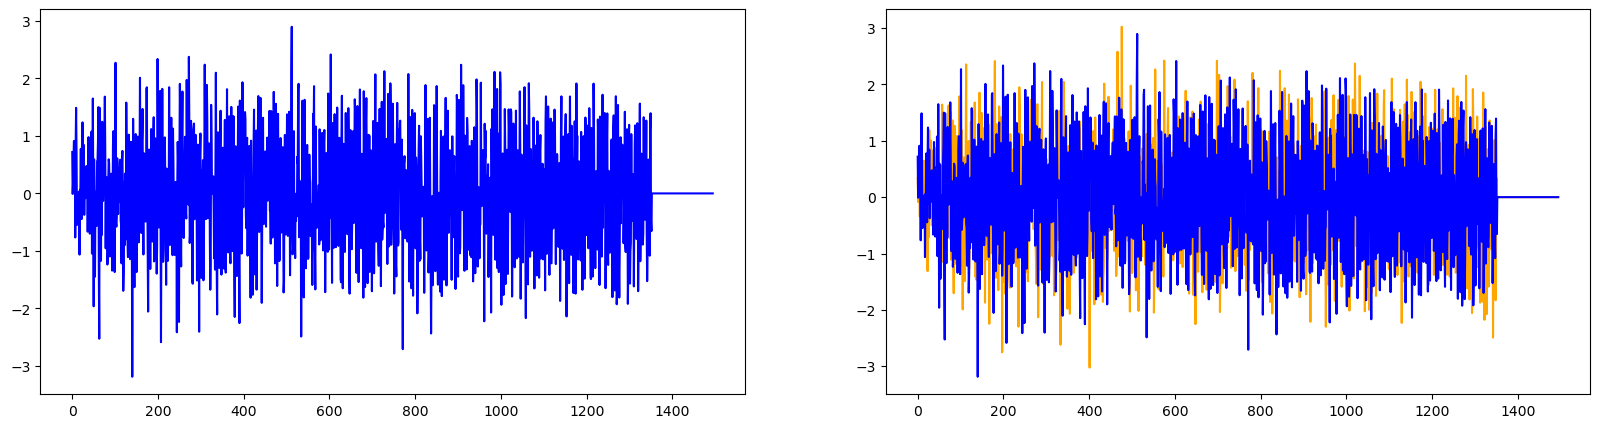

In [17]:

def explain_mode(dataset):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

        LSTMmodel = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        LSTMmodel.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        
        
        dataset_batch = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=LSTMmodel.collate)
        for data, labels, _ in dataset_batch:
            data = data.to(c.device)
            
            for i, d, l in zip(range(len(data)), data, labels):                
                fig, axs = plt.subplots(1, 2, figsize=(20, 5))
                for class_idx in range(2): 
                    # shap_class = shap_values[i, :, :, class_idx].sum(axis=1)
                    
                    real_data = data[i, :, 0].cpu().numpy()
                    imag_data = data[i, :, 1].cpu().numpy()
                    
                    axs[class_idx].plot(real_data, color='blue') # plot(x, y)
                    axs[class_idx+1].plot(imag_data, color='orange')
                    # shap_pos = np.where(shap_class >= 0, shap_class, np.nan)
                    # shap_neg = np.where(shap_class < 0, shap_class, np.nan)
                    
                    # ax2 = axs[class_idx].twinx()
                    # ax2.plot(shap_pos, label='Positive SHAP', color='orange', linestyle='--', alpha=0.7)
                    # ax2.plot(shap_neg, label='Negative SHAP', color='blue', linestyle='--', alpha=0.7)
 
                    # ax2.set_ylim(-0.06, 0.053)
                    # ax2.set_yticks([])
                    # ax2.legend(loc='upper right')
                    
                    # axs[class_idx].set_title(f'Class {class_idx}')
                    # axs[class_idx].set_xlabel('Time')
                    # axs[class_idx].set_ylabel('SHAP value')
                    
                    # axs[class_idx].grid(True)
                    
                plt.suptitle(f'SHAP values for {l} Sample {i} at SNR {snr_str}')
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
                break
            break
        break
        
explain_mode(explain_dataset)

# 데이터셋을 불러오는 과정에서 패딩은 해당 배치에서 가장 길이가 긴 값을 기준으로 이루어지기 때문에 data의 일부가 0으로 되어있을 수 있음
# 
# shap 값은 해당 데이터의 실제 값과 비교하여 어떤 부분이 중요한지를 나타내는 값이기 때문에 0으로 패딩된 부분은 중요하지 않음
# 따라서 shap 값을 보기 위해서는 해당 데이터의 실제 값만을 보는 것이 좋음
# 이를 반영해 코드는 수정

In [1]:
import os
import re
import torch
import glob
import json

import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from TripletConvolution import TCN, trainTCN

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

signalTypes = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

RawType = "/data/kiwan/dataset-CWD-50/"
TransformedTypes = {'DWT' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/dataset-SPWVD-denoised-Adaptive_DWT",
                    'CWD' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/240523_CWD-v1/",
                    'SAFI' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/240523_SAFI-v1/",}


In [6]:
json_file = 'dataset/CWD_signals.json'

with open(json_file, 'r') as f:
    SignalData = json.load(f)

In [65]:
# [signal_type]>[snr_value]>[step]>[timepoint][real, imag]

import matplotlib.pyplot as plt
from torch.utils.data import Dataset


import torch.nn.utils.rnn as rnn_utils

class RadarSignalDataset(Dataset):
    def __init__(self, signals_data, signal_types, snr_max=17):
        self.data = []
        self.labels = []
        self.label_mapping = {signal: idx for idx, signal in enumerate(signalTypes)}

        for signal_type in signal_types:
            print(f"Data loading for '{signal_type}'", end='')
            for snr_idx, snr in enumerate(range(0, snr_max, 2)): 
                print(".", end='') if snr_idx % 2 == 0 else None
                ssnr = str(snr)
                if ssnr in signals_data[signal_type]: 
                    signal_snr_data = signals_data[signal_type][ssnr]
                    for signal in signal_snr_data:
                        complex_signal = [self.convIQ(x) for x in signal]
                        self.data.append(complex_signal)
                        self.labels.append(signal_type)
            print("Done!")
    
    @staticmethod
    def convIQ(datastring):
        comp = complex(datastring.replace('i', 'j'))
        return comp.real, comp.imag
    
    staticmethod
    def collate(self, batch):
        data, labels = zip(*batch)
        padding = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        labels = [self.label_mapping[label] for label in labels]
        labels = torch.tensor(labels, dtype=torch.long)
        return padding, labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [66]:
typeSize = 4
dataset = RadarSignalDataset(SignalData, signalTypes[0:typeSize], snr_max=17)

Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!


In [68]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)

Train batch data size: torch.Size([32, 1856, 2])
Train batch labels: torch.Size([32])
Test batch data size: torch.Size([32, 1920, 2])
Test batch labels: torch.Size([32])


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initial hidden state와 cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))     # LSTM 출력: (배치 크기, 시퀀스 길이, hidden state 크기)
        out = self.fc(out[:, -1, :])        # 마지막 타임스텝만 사용하여 출력 계산
        return out

input_size = 2          # (Real, Imag)
hidden_size = 128       # LSTM hidden state size
num_layers = 2          
num_classes = len(signalTypes[:typeSize])  # Expected Output size

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [74]:
num_epochs = 40 
batch_size = 128

for epoch in range(num_epochs):
    model.train()  
    rl = 0.0
    
    for data_batch, labels_batch in train_loader:
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(data_batch)

        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        rl += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {rl/len(train_loader):.4f}')
torch.save(model.state_dict(), f'./lstm_l{rl/len(train_loader):.4f}.pt')

model.eval() 
correct = 0
total = 0

with torch.no_grad():
    for data_batch, labels_batch in test_loader:
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(data_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch [1/40], Loss: 0.4966
Epoch [2/40], Loss: 0.4733
Epoch [3/40], Loss: 0.3970
Epoch [4/40], Loss: 0.5445
Epoch [5/40], Loss: 0.5509
Epoch [6/40], Loss: 0.4634
Epoch [7/40], Loss: 0.3565
Epoch [8/40], Loss: 0.3428
Epoch [9/40], Loss: 0.4956
Epoch [10/40], Loss: 0.5562
Epoch [11/40], Loss: 0.4643
Epoch [12/40], Loss: 0.3316
Epoch [13/40], Loss: 0.2909
Epoch [14/40], Loss: 0.6296
Epoch [15/40], Loss: 0.7437
Epoch [16/40], Loss: 0.5196
Epoch [17/40], Loss: 0.5252


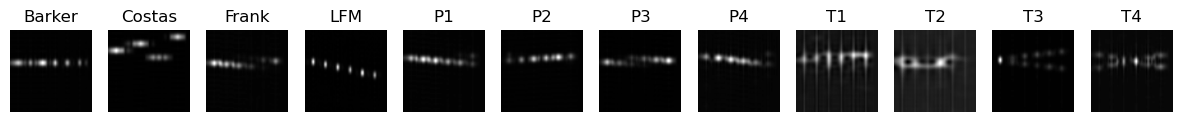

In [5]:
version = 0
targetSNR = 0

vDataset = [(d,l,s) for d, l, s, _ in Dataset if s == targetSNR and signalTypes[l] in signal_groups[f'v{version}']]

plot = {}
for data, label, _ in vDataset:
    signalType = signalTypes[label]
    if signalType not in plot:
        plot[signalType] = data

fig, axs = plt.subplots(1, len(plot))
fig.set_size_inches(15, 5)

for i, (signal_type, image) in enumerate(plot.items()):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(signal_type)
    axs[i].axis('off')

plt.show()

In [ ]:
tcn = TCN(input_channel=1).cuda() 
optimizer = optim.Adam(tcn.parameters(), lr=1e-4)


maxSNR = 2
unique_labels = np.unique([l for _, l, _ in vDataset])

for snr in range(0, maxSNR, 2):
    snrDataset = [(d,l,s) for d, l, s in vDataset if s == snr]
    trainTCN(tcn, optim=optimizer, dataset=snrDataset, data_type='DWT', snr=snr, epochs=20)